In [4]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense ,LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import load_model

2023-03-02 14:17:48.606135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 14:17:48.844336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 14:17:48.844362: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-02 14:17:49.691438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [8]:
df = pd.read_csv('prices.txt',index_col='Date',parse_dates=True)  

In [9]:
data = df.filter(['Price'])

In [10]:
df.describe().transpose()

count      mean         std        min        25%        50%      75%  \
Price  1259.0  274.6248  318.157961  35.793999  60.817999  70.489998  488.125   

               max  
Price  1229.910034

In [11]:
df.isnull().sum()


Price    0
dtype: int64

In [12]:
dataset = data.values
dataset.shape

(1259, 1)

In [13]:
training_data_len = int(len(dataset) *.8)

In [14]:
training_data_len

1007

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01648416],
       [0.01583431],
       [0.01289992],
       ...,
       [0.74250405],
       [0.74330801],
       [0.70391482]])

In [16]:
train_data = scaled_data[:training_data_len,:]
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    # to check
    if i<= 60:
        print(x_train)
        print(y_train)
        

[array([0.01648416, 0.01583431, 0.01289992, 0.01306908, 0.01126524,
       0.01189499, 0.01190002, 0.01197706, 0.01215962, 0.01209933,
       0.01166051, 0.01137243, 0.01104248, 0.01083982, 0.01125519,
       0.01323657, 0.01285637, 0.0139149 , 0.01382278, 0.01389312,
       0.01201056, 0.01273578, 0.01269726, 0.01410081, 0.01528327,
       0.01649421, 0.01648249, 0.01657293, 0.01663658, 0.02002318,
       0.02089077, 0.01943362, 0.02005333, 0.02069648, 0.02234624,
       0.02172988, 0.0197418 , 0.02094101, 0.02051224, 0.02031293,
       0.0211956 , 0.02069146, 0.02120899, 0.02161599, 0.02258072,
       0.02197441, 0.02171649, 0.02262762, 0.02409481, 0.02343491,
       0.02211678, 0.01951067, 0.02166959, 0.0214753 , 0.02383185,
       0.02449511, 0.02414004, 0.02442644, 0.02293077, 0.02312003])]
[0.021294413821350285]


In [17]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape


(947, 60, 1)

In [19]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape= (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
#########dont Click 2 next cell ###### and click load model

In [48]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

947/947 [==============================] - 17s 18ms/step - loss: 5.0378e-04


In [58]:
model.save("TimeSeriesPredictions.h5")

In [21]:
model = load_model("TimeSeriesPredictions.h5")

In [22]:
test_data = scaled_data[training_data_len-60: ,:]
x_test =[]
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [23]:
x_test = np.array(x_test)

In [24]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 11ms/step


In [26]:
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

28.592478934012274

/tmp/ipykernel_29686/4122145859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


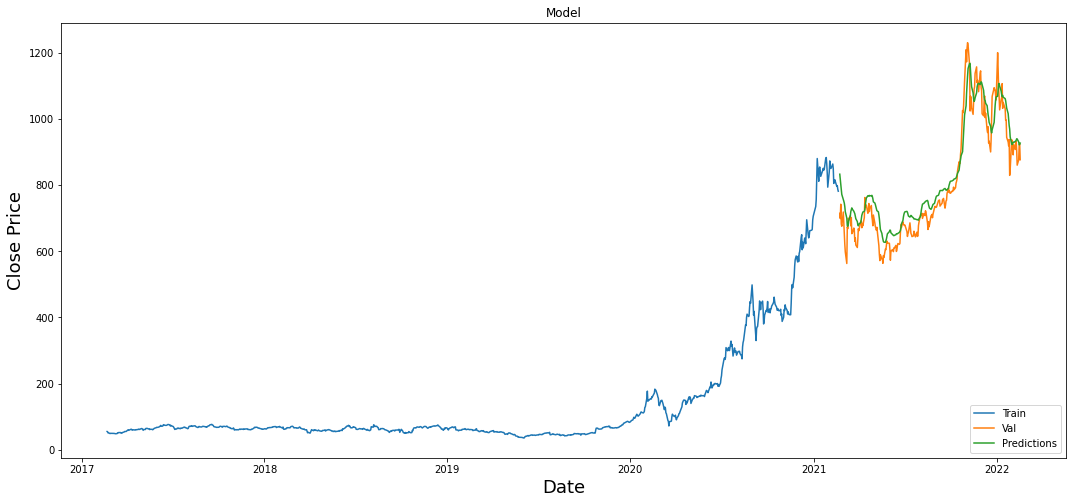

In [27]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(18,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()